Title: Predicting Player Rank Categories Based on the Number of Seasons Active, Prize Money Won, Age, and Height Statistics of the Top 500 Players 


Background Information: 
In tennis, player rankings are determined based on the number of points a player obtains. Players are able to acquire points through competing in tournaments. Winning higher-status tournaments, such as a Grand Slam, results in more points to be gained (2000 points). Additionally, winning tournaments lets players earn prize money, where like points, winning a higher-status tournament gives more prize money (Nag, 2022). Higher-ranking players are therefore more likely to have earned more prize money. Moreover, players who have competed in more seasons have had more opportunities to win tournaments, possibly indicating that they have a higher ranking. 


Question: 
The question we will be exploring in this project is: Can we use known player statistics, such as the number of seasons active, prize money, age, and height of the top 500 players to predict which category an unknown player will reside in? The categories are divided into those in the top 25 percent of the ranks, those in between the top 25 and top 50 percent, those in between the top 50 and top 75 percent, and the rest.



Variables: We will be using age, height, prize money won, and total seasons active to predict the rank of an unknown player. 75 percent of the data will be used to train our classifier, and 25 percent will be used to test it. We will visualize our results using a scatter or line plot. 


We expect that individuals with a high rank will fulfill the following criteria: large number of seasons played, greater prize money earned,  age in their mid-20s, and taller height. Greater prize money earned is likely the strongest predictor for rank as it can be expected that greater prize money earned is correlated with more wins. 

A practical use of our findings could be that it would help identify skilled players when placing sports bets. Alternatively, this result could be used by tennis fans to identify upcoming stars in tennis. 
If given more physical attributes, it may be possible to predict the country of origin of the players using their physical trait

Bibliography:

Nag, U. (2022, April 5). Tennis rankings: Everything you need to know. Olympics.Com. https://olympics.com/en/news/tennis-rankings-atp-wta-men-women-doubles-singles-system-grand-slam-olympicss.




In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
library(readxl)
library(janitor)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (24): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (14): ...1, Prize Money, Turned Pro, Seasons, Titles, Best Season, Retir...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,rank,prize_money,height_cm,seasons,category
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
33,1,119601561,185.0000,19,top_25_percent
32,2,139144944,188.0000,17,top_25_percent
38,3,129231891,185.0000,22,top_25_percent
23,4,10507693,185.7913,5,top_25_percent
26,5,22132368,185.0000,10,top_25_percent
21,6,10425605,185.7913,4,top_25_percent


mean_age,rank,mean_prize_money,mean_height_cm,mean_seasons
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
25.87027,250.7486,3474670,185.8046,6.389225


category,age_mean,average_rank,prize_money_mean,height_cm_mean,average_seasons
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
top_100_percent,24.30645,434.98387,1566300,185.7080,5.254873
top_25_percent,27.39516,63.12903,8864071,185.6907,8.935484
top_25to50_percent,26.69106,187.00000,2056045,185.9902,6.072736
top_50to75_percent,25.44715,311.00000,1202990,185.7778,5.770705


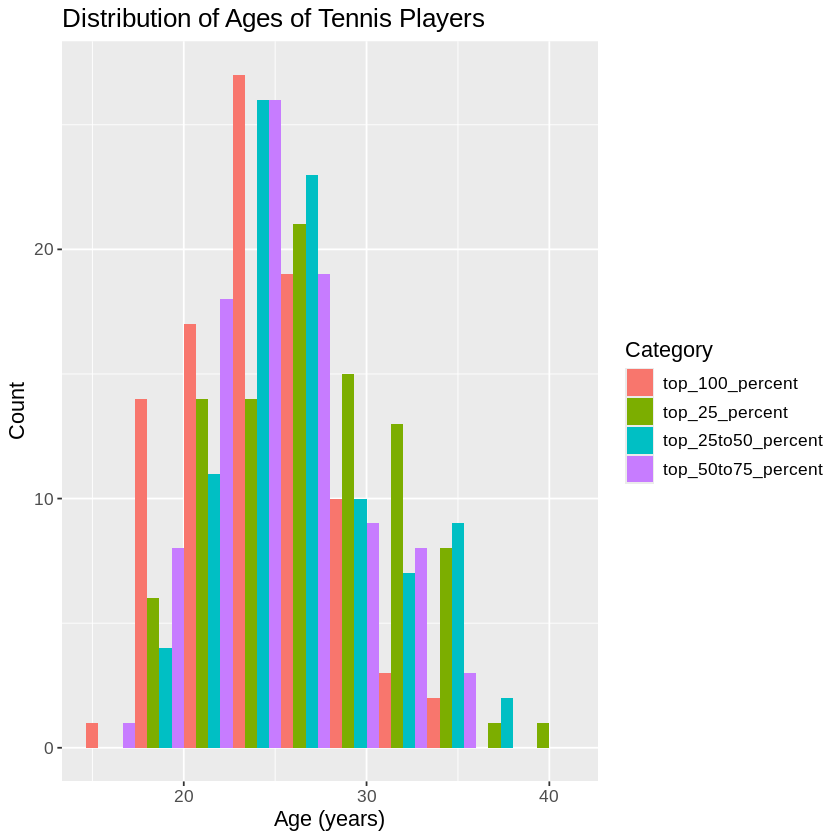

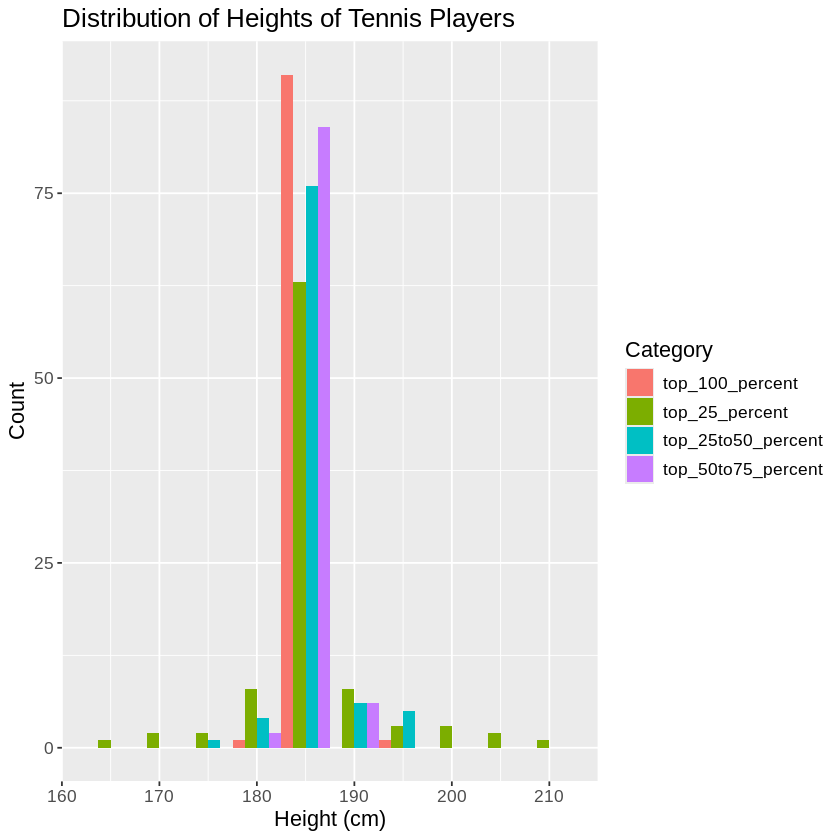

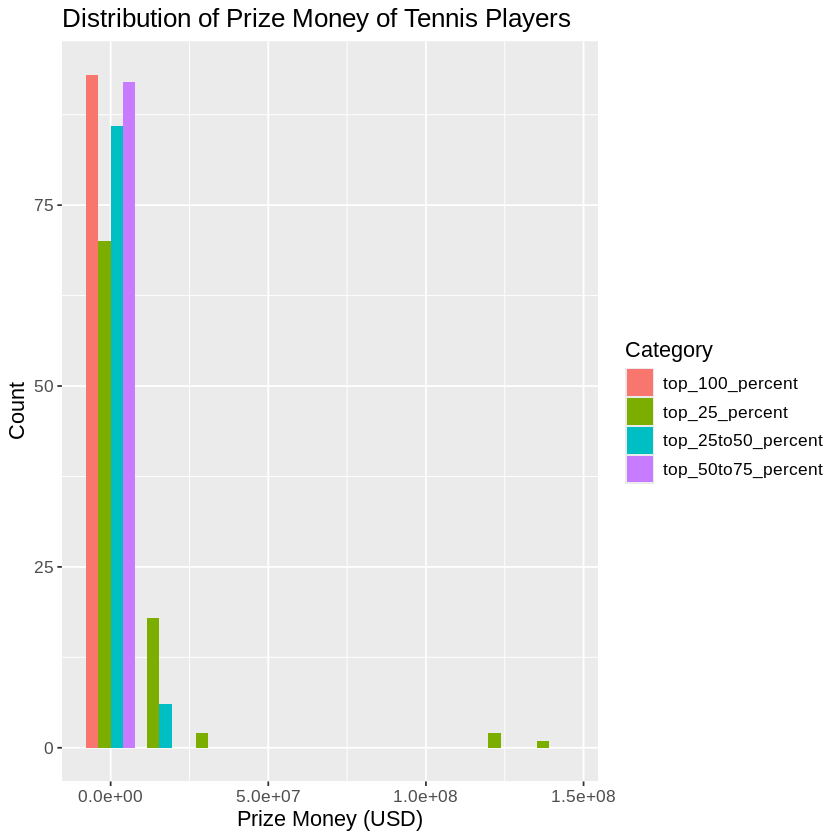

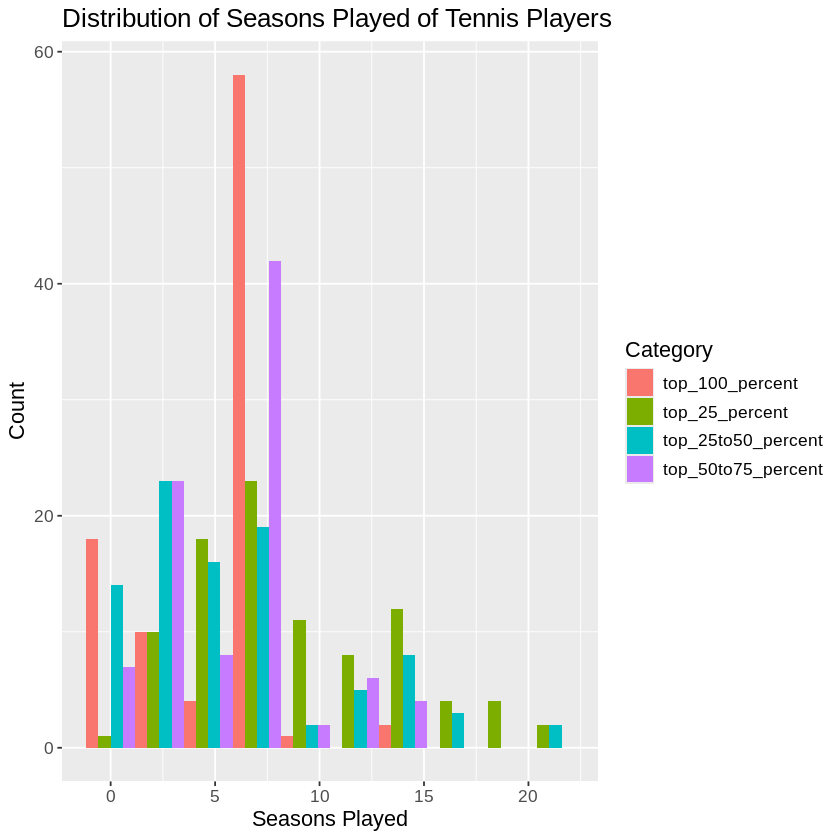

In [11]:
tennis_data <- read_csv("Data/player_stats.csv", skip = 1)
set.seed(22)

# loading in data
tennis_df <- tennis_data |>
    clean_names() |>
    select(age, current_rank, prize_money, height, seasons) |>
    separate(col = height, 
            into = c("height_cm", "discard"), 
           sep = " ") |>
    separate(col = current_rank, 
            into = c("rank", "discard_1"), 
           sep = " ") |>
    separate(col = age, 
            into = c("age", "discard_2"), 
           sep = " ") |>
    select(-discard_2, -discard_1, -discard) |>
    mutate(age = as.numeric(age),
           rank = as.numeric(rank),
           height_cm = as.numeric(height_cm)) |>
           arrange(desc(rank))

means <- tennis_df |>
            select(age:seasons) |>
            map_dfr(mean, na.rm = TRUE)

tennis_df <- tennis_df |>
        replace_na(list(age = 25.96794, 
                        prize_money = 3416440, 
                        height_cm = 185.7913, 
                        seasons = 6.494652)) |>
    arrange(rank)
    

rank_quantile <- tennis_df |>
    select(rank) |>
    quantile(probs = c(0.25, 0.5, 0.75), na.rm = TRUE)

# tidying data
category_columns <- tennis_df |>
    mutate(top_25_percent = rank < 125.5) |>
    mutate(top_25to50_percent = 125.5 < rank & rank < 249) |>
    mutate(top_50to75_percent = 249 < rank & rank < 372.5) |>
    mutate(top_100_percent = 372.5 < rank) 

tennis_df_longer <- category_columns |> 
    pivot_longer(cols = top_25_percent:top_100_percent, 
                 names_to = "category", 
                 values_to = "status") |>
    filter(status == "TRUE") |>
    select(-status) |>
    drop_na()
head(tennis_df_longer)

# splitting data
tennis_split <- initial_split(tennis_df_longer, prop = 0.75, strata = category)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

# summary table
tennis_train_dbl <- tennis_train |>
    mutate(age = as.numeric(age)) |>
    mutate(prize_money = as.numeric(prize_money)) |>
    mutate(height_cm = as.numeric(height_cm)) |>
    mutate(seasons = as.numeric(seasons)) 

summary_table <- tennis_train_dbl |>
    select(age:seasons) |>
    map_dfr(mean, na.rm = TRUE) |>
    rename(mean_age = age,
          mean_prize_money = prize_money,
          mean_height_cm = height_cm,
          mean_seasons = seasons)
summary_table

summary_by_category <- tennis_df_longer |> 
    group_by(category) |> 
    summarize(age_mean = mean(age), average_rank = mean(rank), 
              prize_money_mean = mean(prize_money), 
              height_cm_mean = mean(height_cm), 
              average_seasons = mean(seasons))
summary_by_category


# data visualizations
tennis_viz_histo_age <- tennis_train |>
    ggplot(aes(x = age, fill = category)) +
    geom_histogram(position = "dodge", bins = 10) +
    xlab("Age (years)") +
    ylab("Count") +
    ggtitle("Distribution of Ages of Tennis Players") +
    labs(fill = "Category") +
    theme(text = element_text(size=13))
tennis_viz_histo_age

tennis_viz_histo_height <- tennis_train |>
    ggplot(aes(x = height_cm, fill = category)) +
    geom_histogram(position = "dodge", bins = 10) +
    xlab("Height (cm)") +
    ylab("Count") +
    ggtitle("Distribution of Heights of Tennis Players") +
    labs(fill = "Category") +
    theme(text = element_text(size=13))
tennis_viz_histo_height

tennis_viz_histo_prize <- tennis_train |>
    ggplot(aes(x = prize_money, fill = category)) +
    geom_histogram(position = "dodge", bins = 10) +
    xlab("Prize Money (USD)") +
    ylab("Count") +
    ggtitle("Distribution of Prize Money of Tennis Players") +
    labs(fill = "Category") +
    theme(text = element_text(size=13))
tennis_viz_histo_prize

tennis_viz_histo_seasons <- tennis_train |>
    ggplot(aes(x = seasons, fill = category)) +
    geom_histogram(position = "dodge", bins = 10) +
    xlab("Seasons Played") +
    ylab("Count") +
    ggtitle("Distribution of Seasons Played of Tennis Players") +
    labs(fill = "Category") +
    theme(text = element_text(size=13))
tennis_viz_histo_seasons
